In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import regularizers
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

2023-05-21 08:23:57.704862: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# configure Keras to use GPU
tf.config.experimental.set_visible_devices([], 'GPU')

# Load the dataset
df = pd.read_csv("paysim.csv")


In [4]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [5]:
# Drop irrelevant columns
df = df.drop(['nameOrig', 'nameDest'], axis=1)

# Encode categorical features
df['type'] = df['type'].replace({'CASH_OUT': 0, 'TRANSFER': 1, 'PAYMENT': 2, 'DEBIT': 3, 'CASH_IN': 4})

# Standardize the features
scaler = StandardScaler()
df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']] = scaler.fit_transform(df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])

# Split the dataset into features and target
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Apply SMOTE Oversampling to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [7]:
# Fit the random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

Accuracy: 0.9991913708503729
Confusion matrix:
 [[1269940     964]
 [     65    1555]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.62      0.96      0.75      1620

    accuracy                           1.00   1272524
   macro avg       0.81      0.98      0.88   1272524
weighted avg       1.00      1.00      1.00   1272524



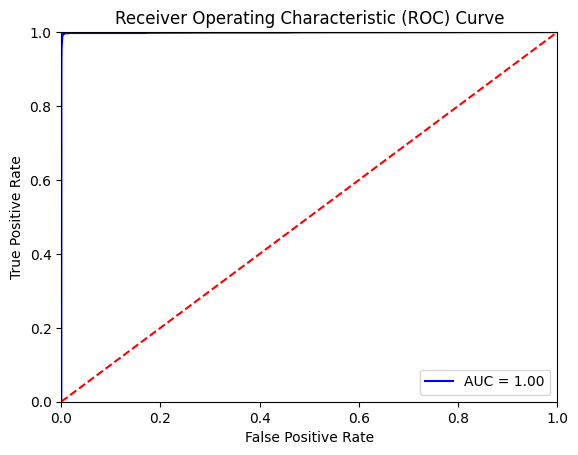

In [8]:
# Make predictions on the test set
y_pred = rf.predict(X_test)

# Compute the accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Confusion matrix:\n', cm)

from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, auc, matthews_corrcoef, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred))

y_pred_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

In [9]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity = recall
auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy: %f" % accuracy)
print("F1-score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("Specificity: ", specificity)
print("Sensitivity: ", sensitivity)
print("AUC: ", auc)

mcc = matthews_corrcoef(y_test, y_pred)

print("Matthews correlation coefficient:", mcc)

# plot the loss graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Autoencoder model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Accuracy: 0.999191
F1-score:  0.7513892244503504
Precision:  0.6173084557364034
Recall:  0.9598765432098766
Specificity:  0.9992414848013698
Sensitivity:  0.9598765432098766
AUC:  0.9988924006304678
Matthews correlation coefficient: 0.7694300359459979


NameError: name 'history' is not defined

In [1]:
##

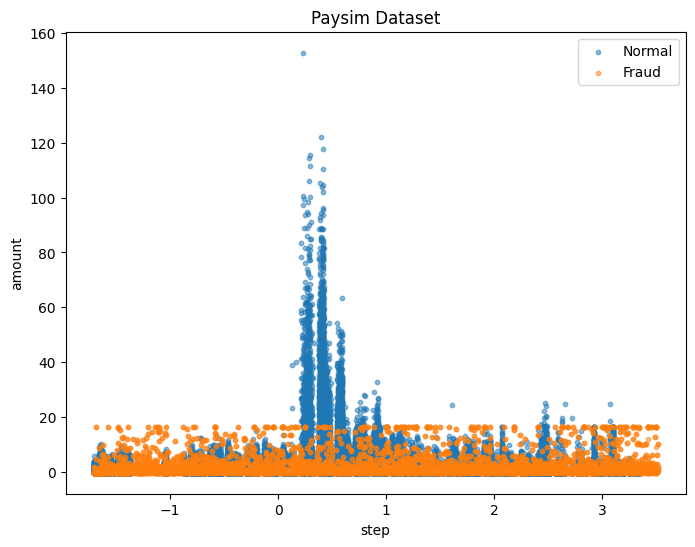

In [10]:
# Separate the normal and fraud data
normal_data = df[df['isFraud'] == 0]
fraud_data = df[df['isFraud'] == 1]

# Plotting the point distribution
plt.figure(figsize=(8, 6))
plt.title("Paysim Dataset")
plt.scatter(normal_data['step'], normal_data['amount'], label='Normal', s=10, alpha=0.5)
plt.scatter(fraud_data['step'], fraud_data['amount'], label='Fraud', s=10, alpha=0.5)
plt.xlabel("step")
plt.ylabel("amount")
plt.legend()
plt.show()

In [11]:
df1 = np.column_stack([X_train_balanced, y_train_balanced])
df2 = np.column_stack([X_test, y_test])

In [12]:
df3 = np.vstack([df1, df2])

In [13]:
df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,-1.703042,2,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411,0,0
1,-1.703042,2,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411,0,0
2,-1.703042,1,-0.297555,-0.288654,-0.292442,-0.323814,-0.333411,1,0
3,-1.703042,0,-0.297555,-0.288654,-0.292442,-0.317582,-0.333411,1,0
4,-1.703042,2,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411,0,0
...,...,...,...,...,...,...,...,...,...
6362615,3.510123,0,0.264665,-0.171108,-0.292442,-0.323814,-0.240959,1,0
6362616,3.510123,1,10.153953,1.896491,-0.292442,-0.323814,-0.333411,1,0
6362617,3.510123,0,10.153953,1.896491,-0.292442,-0.303665,1.403027,1,0
6362618,3.510123,1,1.109765,0.005581,-0.292442,-0.323814,-0.333411,1,0


In [14]:
df4 = pd.DataFrame(df3, columns = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
                                   'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'isFraud'])

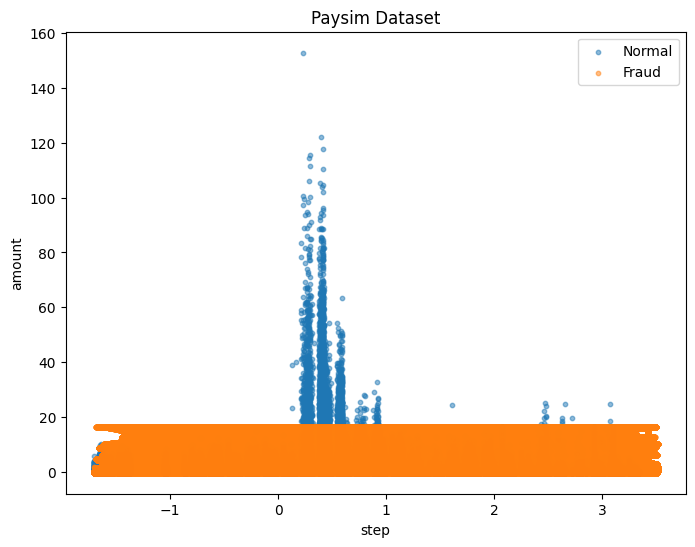

In [15]:
# Separate the normal and fraud data
normal_data = df4[df4['isFraud'] == 0]
fraud_data = df4[df4['isFraud'] == 1]

# Plotting the point distribution
plt.figure(figsize=(8, 6))
plt.title("Paysim Dataset")
plt.scatter(normal_data['step'], normal_data['amount'], label='Normal', s=10, alpha=0.5)
plt.scatter(fraud_data['step'], fraud_data['amount'], label='Fraud', s=10, alpha=0.5)
plt.xlabel("step")
plt.ylabel("amount")
plt.legend()
plt.show()